In [113]:
#Import packaging that may be needed
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import datetime as dt

#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

import math
from collections import OrderedDict
from netCDF4 import Dataset
import netCDF4
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [126]:
#Precipitation (Monthly Mean)
dataset1 = Dataset('precip.mon.mean.nc')
print(dataset1.variables.keys())
print(dataset1.variables['lat'][:].min(), dataset1.variables['lat'][:].max())
print(dataset1.variables['lon'][:].min(), dataset1.variables['lon'][:].max())

#Outgoing longwave radiation OLR (Monthly Mean)
dataset2 = Dataset('olr.mon.mean.nc')
print(dataset2.variables.keys())
print(dataset2.variables['lat'][:].min(), dataset2.variables['lat'][:].max())
print(dataset2.variables['lon'][:].min(), dataset2.variables['lon'][:].max())

#Air Temperature (Monthly Mean)
dataset3 = Dataset('air.mon.mean.nc')
print(dataset3.variables.keys())
print(dataset3.variables['lat'][:].min(), dataset3.variables['lat'][:].max())
print(dataset3.variables['lon'][:].min(), dataset3.variables['lon'][:].max())

odict_keys(['lat', 'lon', 'time', 'precip'])
-88.75 88.75
1.25 358.75
odict_keys(['lon', 'olr', 'time', 'lat'])
-90.0 90.0
0.5 359.5
odict_keys(['lat', 'lon', 'time', 'air'])
-90.0 90.0
0.0 357.5


In [127]:
#Credit to https://stackoverflow.com/questions/28420988/how-to-read-netcdf-file-and-write-to-csv-using-python
#Precip netcdf variables
precip_lat = dataset1.variables['lat'][:] + 90
precip_lon = dataset1.variables['lon'][:]
precip_time_var = dataset1.variables['time']
precip_dtime = netCDF4.num2date(precip_time_var[:],precip_time_var.units)

#OLR netcdf variables
olr_lat = dataset2.variables['lat'][:] + 90
olr_lon = dataset2.variables['lon'][:]
olr_time_var = dataset2.variables['time']
olr_dtime = netCDF4.num2date(olr_time_var[:],olr_time_var.units)

#Air temp netcdf variables
air_lat = dataset3.variables['lat'][:] + 90
air_lon = dataset3.variables['lon'][:]
air_time_var = dataset3.variables['time']
air_dtime = netCDF4.num2date(air_time_var[:],air_time_var.units)

In [128]:
a = pd.read_csv("WGMS-FoG-2018-11-EE-MASS-BALANCE.csv", usecols=[2,7,9,11,3])
a.replace(["NaN", 'NaT'], np.nan, inplace = True)
a = a.dropna()

b = pd.read_csv("WGMS-FoG-2018-11-EEE-MASS-BALANCE-POINT.csv", usecols=[2,7,8])
b.replace(["NaN", 'NaT'], np.nan, inplace = True)
b = b.dropna()
b.drop_duplicates(subset='WGMS_ID', inplace = True)
b['POINT_LAT'] += 90
b['POINT_LON'] += 180
merged = a.merge(b, on='WGMS_ID')
#b = b.dropna(axis=1)

merged.to_csv("GlacialData.csv", index=False)

In [129]:
# find closest index to specified value
def near(array,value):
    idx=np.argmin(np.abs(array-value))
    return idx

In [130]:
c = pd.read_csv("GlacialData.csv")
'''
cols = ['WGMS_ID', 'YEAR', 'WINTER_BALANCE', 'SUMMER_BALANCE', 'POINT_LAT'
          , 'POINT_LONG', 'PRECIP_OCT', 'PRECIP_NOV', 'PRECIP_DEC', 'PRECIP_JAN', 'PRECIP_FEB',
          'PRECIP_MAR', 'PRECIP_APR', 'PRECIP_MAY', 'PRECIP_JUN', 'PRECIP_JUL', 'PRECIP_AUG', 'PRECIP_SEP',
          'OLR_OCT', 'OLR_NOV', 'OLR_DEC', 'OLR_JAN', 'OLR_FEB',
          'OLR_MAR', 'OLR_APR', 'OLR_MAY', 'OLR_JUN', 'OLR_JUL', 'OLR_AUG', 'OLR_SEP',
          'AIR_OCT', 'AIR_NOV', 'AIR_DEC', 'AIR_JAN', 'AIR_FEB',
          'AIR_MAR', 'AIR_APR', 'AIR_MAY', 'AIR_JUN', 'AIR_JUL', 'AIR_AUG', 'AIR_SEP']
'''
cols = ['WGMS_ID', 'YEAR', 'MASS_BALANCE', 'POINT_LAT', 'POINT_LONG', 'PRECIP_M1', 'PRECIP_M2', 'PRECIP_M3', 
        'PRECIP_M4', 'PRECIP_M5','PRECIP_M6','OLR_M1', 'OLR_M2', 'OLR_M3', 
        'OLR_M4', 'OLR_M5','OLR_M6','AIR_M1', 'AIR_M2', 'AIR_M3', 'AIR_M4', 'AIR_M5','AIR_M6',]
with open('WinterMass.csv', 'w+') as myfile, open('SummerMass.csv', 'w+') as summer:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    sr = csv.writer(summer, quoting=csv.QUOTE_ALL)
    wr.writerow(cols)
    sr.writerow(cols)
    for i in c.itertuples():
        #Create WINTER AND SUMMER row to add to dataframe and initialise with values
        winter_row = list(i[1:])
        del winter_row[4]
        del winter_row[3]
        
        summer_row = list(i[1:])
        del summer_row[4]
        del summer_row[2]
        
        #Initial csv variables
        WGMS_ID = i[1]
        YEAR = int(i[2])
        WINTER_BALANCE = i[3]
        SUMMER_BALANCE = i[4]
        POINT_LAT = int(i[6])
        POINT_LONG = int(i[7])
        
        #Nearest precip coordinates
        precip_ix = near(precip_lon, POINT_LONG)
        precip_iy = near(precip_lat, POINT_LAT)
        
        #Nearest olr coordinates
        olr_ix = near(olr_lon, POINT_LONG)
        olr_iy = near(olr_lat, POINT_LAT)
        
        #Nearest air temp coordinates
        air_ix = near(air_lon, POINT_LONG)
        air_iy = near(air_lat, POINT_LAT)
        
        #One year timeframe based on given year. Take Oct prev year through Sept of given year
        start = dt.datetime(YEAR - 1,10,1,0,0,0)
        stop = dt.datetime(YEAR,9,30,0,0,0)
        
        #Precip start/stop indexes
        precip_istart = netCDF4.date2index(start,precip_time_var,select='nearest')
        precip_istop = netCDF4.date2index(stop,precip_time_var,select='nearest')
        
        #OLR start/stop indexes
        olr_istart = netCDF4.date2index(start,olr_time_var,select='nearest')
        olr_istop = netCDF4.date2index(stop,olr_time_var,select='nearest')
        
        #Air start/stop indexes
        air_istart = netCDF4.date2index(start,air_time_var,select='nearest')
        air_istop = netCDF4.date2index(stop,air_time_var,select='nearest')
        
        #Precip variable data
        precip_var = dataset1.variables['precip']
        precip_hs = precip_var[precip_istart:precip_istop,precip_iy,precip_ix]
        
        #OLR variable data
        olr_var = dataset2.variables['olr']
        olr_hs = olr_var[olr_istart:olr_istop,olr_iy,olr_ix]
        
        #Air variable data
        air_var = dataset3.variables['air']
        air_hs = air_var[air_istart:air_istop,air_iy,air_ix]
        
        #Add onto the row with climate variables depending on hemisohere
        
        ####### CHECK ON THE INDEXES SO ONLY 18 GO THROUGH
        if POINT_LAT < 90:
            winter_row.extend(list(precip_hs[:6]))
            winter_row.extend(list(olr_hs[:6]))
            winter_row.extend(list(air_hs[:6]))
            summer_row.extend(list(precip_hs[6:12]))
            summer_row.extend(list(olr_hs[6:12]))
            summer_row.extend(list(air_hs[6:12]))
        else:
            winter_row.extend(list(precip_hs[6:12]))
            winter_row.extend(list(olr_hs[6:12]))
            winter_row.extend(list(air_hs[6:12]))
            summer_row.extend(list(precip_hs[:6]))
            summer_row.extend(list(olr_hs[:6]))
            summer_row.extend(list(air_hs[:6]))
        
        #Write the two rows to the csv
        wr.writerow(winter_row)
        sr.writerow(summer_row)


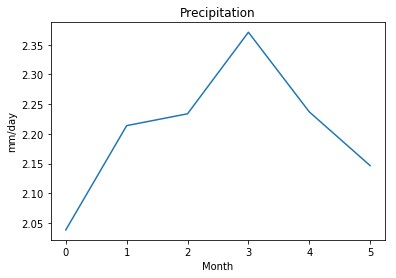

Coefficients Lin Reg: 
 [-0.06387861 -0.12855826 -0.01491673  0.06964654  0.06262189  0.07450956
 -0.00809938 -0.00551591  0.00709747  0.01186639  0.00325471 -0.00459824
 -0.02611694  0.0207561  -0.08180168  0.02293503  0.02711526  0.03410722]
Mean squared error Lin Reg: 0.43
Variance score Lin Reg: 0.57
Percent MLR Correct:  0.6620861961274204


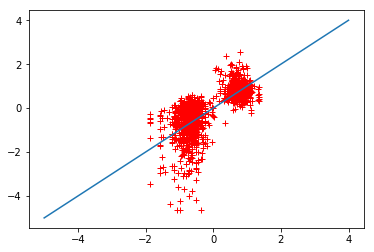

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


[epoch 1, iter   100] loss: 15508.474 elapsed time 0.590
[epoch 1, iter   200] loss: 11.066 elapsed time 0.437
[epoch 2, iter   100] loss: 6.017 elapsed time 0.298
[epoch 2, iter   200] loss: 10.549 elapsed time 0.300
[epoch 3, iter   100] loss: 5.967 elapsed time 0.279
[epoch 3, iter   200] loss: 10.169 elapsed time 0.327
[epoch 4, iter   100] loss: 7.300 elapsed time 0.335
[epoch 4, iter   200] loss: 5.302 elapsed time 0.295
[epoch 5, iter   100] loss: 4.015 elapsed time 0.361
[epoch 5, iter   200] loss: 3.779 elapsed time 0.323
[epoch 6, iter   100] loss: 3.599 elapsed time 0.305
[epoch 6, iter   200] loss: 3.528 elapsed time 0.308
[epoch 7, iter   100] loss: 2.564 elapsed time 0.294
[epoch 7, iter   200] loss: 2.095 elapsed time 0.324
[epoch 8, iter   100] loss: 1.910 elapsed time 0.288
[epoch 8, iter   200] loss: 1.770 elapsed time 0.283
[epoch 9, iter   100] loss: 1.900 elapsed time 0.286
[epoch 9, iter   200] loss: 1.932 elapsed time 0.297
[epoch 10, iter   100] loss: 2.025 elap

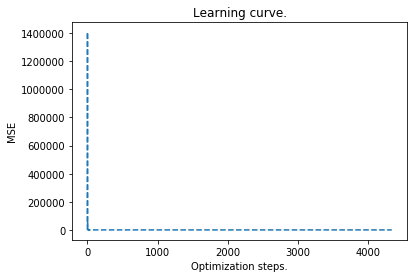

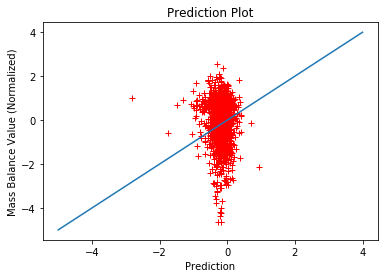

In [168]:
import numpy as np
import torch
import torch.utils.data as data_utils
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import math
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#Add Lin Reg to check as baseline, normalize X-vals, add nonlinearity, check what weights look like

#Takes in csv file and loads it so that it is a pytorch tensor for training and testing data
def loader():
    X_train, y_train, X_test, y_test = None, None, None, None
    
    data = pd.read_csv('FinalGlacialDatasetV3.csv')
    data.replace(["NaN", 'NaT', '--'], np.nan, inplace = True)
    data = data.dropna()
    data.drop(data[data.MASS_BALANCE < -10000].index, inplace=True)
    data = data.values
    y_vals = data[:, 2]
    X_vals = data[:,5:]
    
    indices = np.random.permutation(y_vals.shape[0])
    training_idx, test_idx = indices[:math.floor(y_vals.shape[0] * 0.9)], indices[math.floor(y_vals.shape[0] * 0.9):]
    
    X_train = X_vals[training_idx, :]
    X_train = X_train.astype(dtype = 'float32')
    X_test = X_vals[test_idx,:]
    X_test = X_test.astype(dtype = 'float32')
    y_train = y_vals[training_idx]
    y_test = y_vals[test_idx]
    
    X_plot = np.mean(X_train, axis=0)
    #plt.figure(dpi=1200)
    plt.plot(X_plot[0:6])
    plt.title("Precipitation")
    plt.ylabel("mm/day")
    plt.xlabel("Month")
    #plt.plot(X_plot[6:12])
    #plt.plot(X_plot[12:18])
    #plt.legend(['Precipitation', 'Outgoing Long Wave Radiation', 'Air Temperature'], loc='upper left')
    #plt.savefig("PrecipW.png")
    plt.show()
    
    
    y_mean = np.mean(y_train)
    y_sd = math.sqrt(np.var(y_train))
    x_mean = np.mean(X_train)
    x_sd = math.sqrt(np.var(X_train))
    
    #Normalize the data
    y_train = (y_train - y_mean) / y_sd
    y_test = (y_test - y_mean) / y_sd
    #X_train = (X_train - x_mean) / x_sd
    #X_test = (X_test - x_mean) / x_sd
    
    
    
    return X_train, y_train, X_test, y_test


#Our Model's class
class NeuralNet(nn.Module):
    def __init__(self, hidden_units1=300, hidden_units2=500, output_units=1, inp_units=18):
        super().__init__()

        self.fc1 = nn.Linear(inp_units, hidden_units1)
        self.fc2 = nn.Linear(hidden_units1, output_units)
        self.ReLU = nn.LeakyReLU(negative_slope=0.75, inplace=True)
        self.Tanh = nn.Tanh()
        self.fc = nn.Sequential(
            # N x H1 tensor
            nn.Linear(inp_units, hidden_units1),
            nn.LeakyReLU(negative_slope=.5, inplace=True),
            nn.Dropout(0.2),
            
            # N x H2 tensor
            nn.Linear(hidden_units1, hidden_units2),
            nn.LeakyReLU(negative_slope=.01, inplace=True),
            
            # N x H1 tensor
            nn.Linear(hidden_units2, output_units)
            
            )
        


    def forward(self, x):
        # x is an N x D tensor
        y_hat = self.fc(x)
        return y_hat

#Set weights of model
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    
def NeuralTrain(trainloader, net, criterion, optimizer, device):
    loss_graph = []
    for epoch in range(15):  # loop over the dataset for x number of epochs
        start = time.time()
        running_loss = 0.0

        #For each batch run through model, backprop, and optimize weights
        for i, (data, mass_balance) in enumerate(trainloader):
            data = data.to(device).float()
            mass_balance = mass_balance.to(device).float()
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, mass_balance)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            loss_graph.append(loss.item())
            if i % 100 == 99:
                end = time.time()
                print('[epoch %d, iter %5d] loss: %.3f elapsed time %.3f' % 
                    (epoch + 1, i + 1, running_loss / 100, end - start))
                start = time.time()
                running_loss = 0.0
    
    # Plot learning curve
    fig1, ax1 = plt.subplots()
    ax1.plot(loss_graph, '--')
    ax1.set_title('Learning curve.')
    ax1.set_ylabel('MSE')
    ax1.set_xlabel('Optimization steps.')
    #fig1.savefig('loss2W.png')

    print('Finished Training')

def NeuralTest(testloader, net, criterion, device):
    total = 0
    error = []
    fig2, ax2 = plt.subplots()
    with torch.no_grad():
        for data in testloader:
            representations, mass_balance = data
            representations = representations.to(device).float()
            mass_balance = mass_balance.to(device).float()
            outputs = net(representations)
            loss = criterion(outputs, mass_balance).item()
            length = outputs.numpy().shape[0]
            print('Variance score Neural Net: %.2f' % r2_score(np.reshape(mass_balance.numpy(), (length, 1)),
                                                               outputs.numpy()))
            print("Percent NN Correct: ", len(np.where(abs(outputs.numpy() 
                - np.reshape(mass_balance.numpy(), (length, 1)) < 0.5))[0]) / float(length))
            ax2.plot(outputs.numpy(), np.reshape(mass_balance.numpy(), (length, 1)), 'r+')
            ax2.plot(range(-5,5), range(-5,5))
            ax2.set_title('Prediction Plot')
            ax2.set_ylabel('Mass Balance Value (Normalized)')
            ax2.set_xlabel('Prediction')
            #fig2.savefig('Predictions2W.png')
            error.append(loss)
    print('Error: %s Unit(s)' % (np.mean(error)))

def main():
    #Sets device to cpu or gpu if you have one
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #Gets our datasets loaded
    X_train, y_train, X_test, y_test = loader()
    
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The coefficients
    print('Coefficients Lin Reg: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error Lin Reg: %.2f"
      % mean_squared_error(y_test, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score Lin Reg: %.2f' % r2_score(y_test, y_pred))
    
    print("Percent MLR Correct: ",len(np.where(abs(y_pred - y_test) < 0.5)[0]) / float(len(y_pred)))
    
    
    # Plot outputs
    plt.plot(y_pred, y_test, 'r+')
    plt.plot(range(-5,5), range(-5,5))
    #plt.savefig('LinearRegressionWin.png')
    plt.show()
    
    
    X_train = torch.tensor(X_train.astype(dtype = 'float32'))
    y_train = torch.tensor(y_train.astype(dtype = 'float32'))
    X_test = torch.tensor(X_test.astype(dtype = 'float32'))
    y_test = torch.tensor(y_test.astype(dtype = 'float32'))
    
    
    #Put them into torch datasets with batch size 
    trainset = data_utils.TensorDataset(X_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)

    testset = data_utils.TensorDataset(X_test, y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=y_test.shape[0], shuffle=False)

    #Model and Loss
    net = NeuralNet().to(device)
    net.apply(init_weights)
    criterion = nn.MSELoss()

    #Can also switch from adam to sgd
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.1)

    #Train and Test model
    NeuralTrain(trainloader, net, criterion, optimizer, device)
    NeuralTest(testloader, net, criterion, device)
    


if __name__ == '__main__':
    main()

87


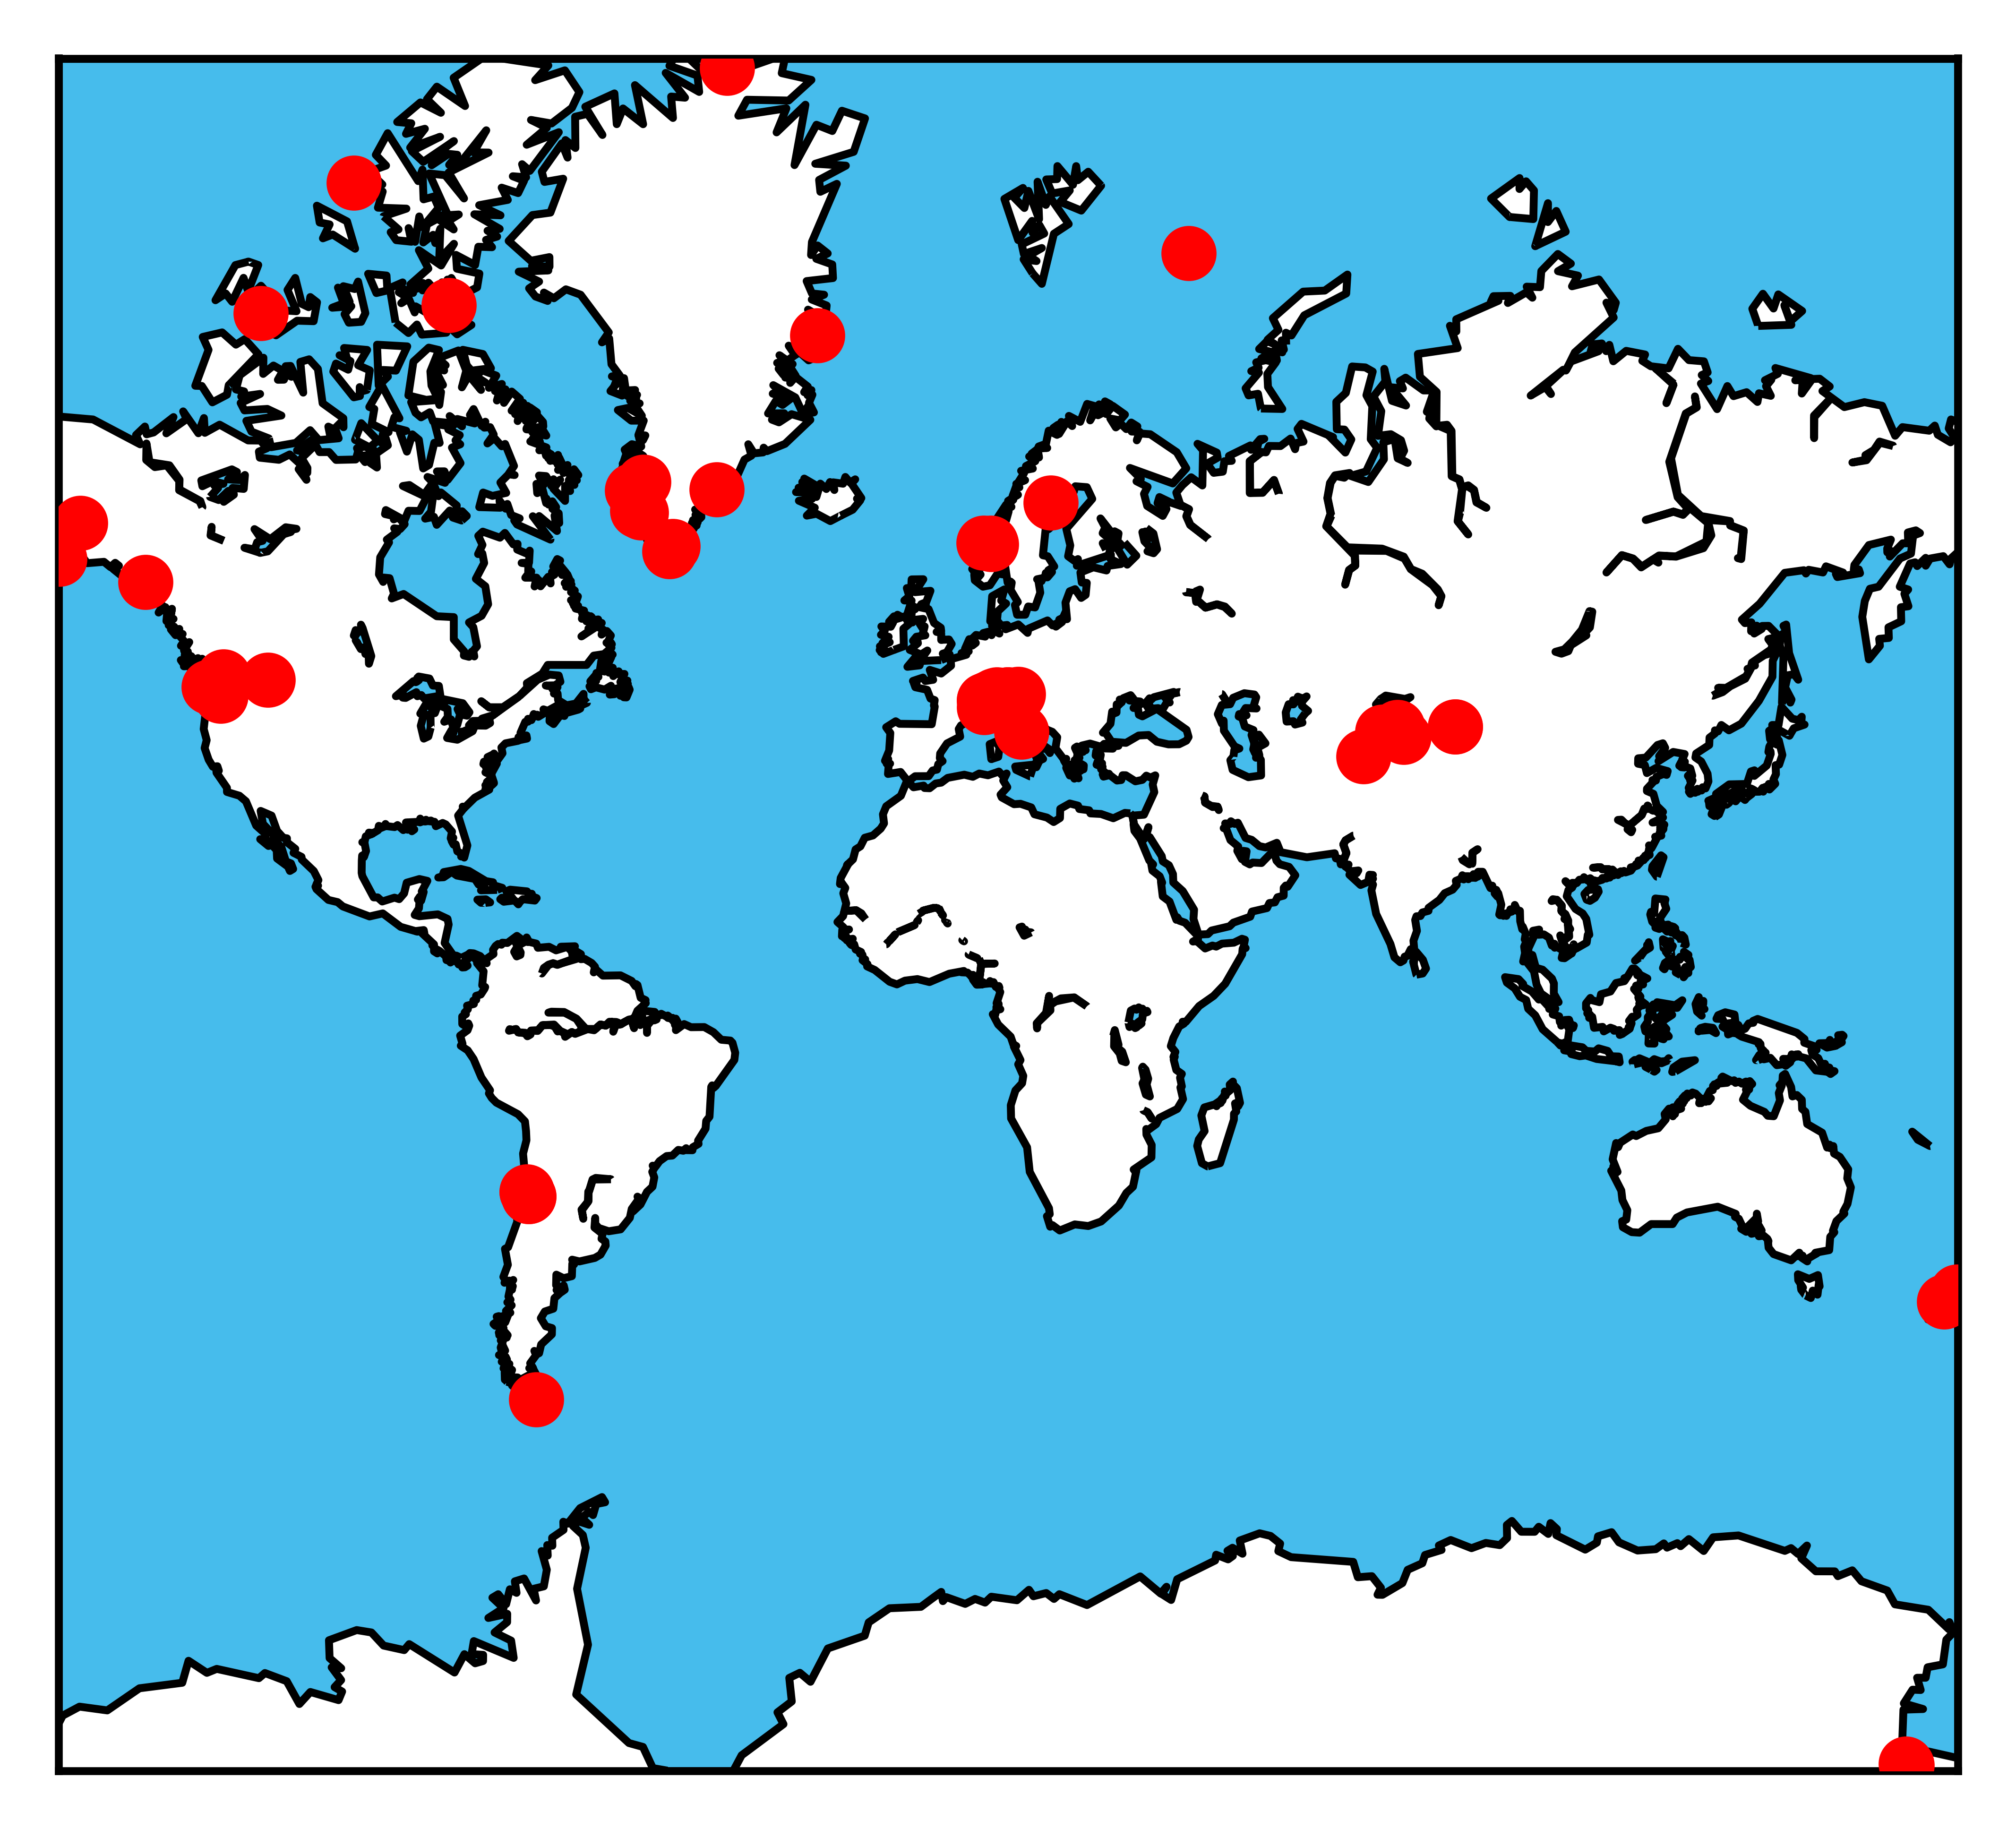

In [90]:
get_coords = merged.drop_duplicates(subset='WGMS_ID')
lati = list(get_coords['POINT_LAT'] - 90)
longi = list(get_coords['POINT_LON'] - 180)
print(len(longi))
'''
ix = near(lon, longi[0])
iy = near(lat, lati[0])

print(lati[0], longi[0])

start = dt.datetime(2010,1,1,0,0,0)
stop = dt.datetime(2015,1,1,0,0,0)

istart = netCDF4.date2index(start,time_var,select='nearest')
istop = netCDF4.date2index(stop,time_var,select='nearest')

#print(istart, istop)



# Get all time records of variable [vname] at indices [iy,ix]
vname = 'precip'
var = dataset1.variables[vname]
hs = var[istart:istop,iy,ix]
tim = dtime[istart:istop]


# Create Pandas time series object
ts = pd.Series(hs,index=tim,name=vname)

# Use Pandas time series plot method
ts.plot(title='Location: Lon=%.2f, Lat=%.2f' % ( lon[ix], lat[iy]),legend=True)
plt.ylabel(var.units);
'''
plt.figure(dpi=1200)
# determine range to print based on min, max lat and long of the data
margin = .2 # buffer to add to the range
lat_min = min(lati) - margin
lat_max = max(lati) + margin
long_min = min(longi) - margin
long_max = max(longi) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            area_thresh=10000.,
            )
m.drawcoastlines()
#m.drawcountries()
#m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and long to map projection coordinates
lons, lats = m(longi, lati)
# plot points as red dots
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
plt.savefig('GlaciersOnMap.png', bbox_inches='tight')
plt.show()